# Statistical inference of Alternative Energy Stock returns

In this notebook we use Ordinary Least Squares Regression to predict 1 day, 5 day, 10 day, and 30 day returns. 

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Load Data

In [4]:
with pd.HDFStore('data.h5') as store:
    data = (store['model_data']
            .dropna()
            .drop(['Open', 'Close', 'Low', 'High'], axis=1))

### Create Model Data

In [5]:
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'Volume'], axis=1)

## Correlation Measurements

These next cells return the top ten values with the highest levels of correlation in the dataset

In [6]:
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False)

In [7]:
corr_mat.head().append(corr_mat.tail())

,var1,var2,corr
460,return_42d,return_63d,0.803484
509,return_63d,return_42d,0.803484
8,rsi,return_21d,0.752417
400,return_21d,rsi,0.752417
1468,return_10d_lag5,return_21d_lag2,0.751635
351,return_10d,bb_high,-0.701080
50,bb_high,rsi,-0.729521
1,rsi,bb_high,-0.729521
1631,year_2020,year_2019,-1.000000
1582,year_2019,year_2020,-1.000000


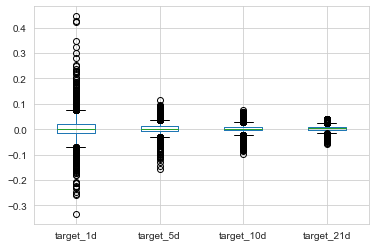

In [8]:
y.boxplot();

## Linear Regression for Statistical Inference: OLS with statsmodels

### Ticker-wise standardization

`statsmodels` warns of high design matrix condition numbers. This can arise when the variables are not standardized and the Eigenvalues differ due to scaling. The following step avoids this warning.

In [9]:
sectors = X.iloc[:, -10:]
X = (X.drop(sectors.columns, axis=1)
     .groupby(level='Ticker')
     .transform(lambda x: (x - x.mean()) / x.std())
    .join(sectors)
    .fillna(0))

### 1-Day Returns

**R-squared:** R-squared is a goodness-of-fit measure for linear regression models. This statistic indicates the percentage of the variance in the dependent variable that the independent variables explain collectively. Our score in this model is **0.071** which indictaes a weak fit for the model. 

**Prob(F-Statistic):** Prob(F-statistics) depicts the probability of null hypothesis being true. As per the above results, probability is nearing to zero. This implies that overall the regression is somewhat meaningful.

**Prob(Omnibus):** One of the assumptions of OLS is that the errors are normally distributed. Omnibus test is performed in order to check this. Prob(Omnibus) is supposed to be close to the 1 in order for it to satisfy the OLS assumption. In this case Prob(Omnibus) is **0.0000**, which implies that the OLS assumption is not satisfied.

**Durbin-watson:** Another assumption of OLS is of homoscedasticity. This implies that the variance of errors is constant. Here, it is **~2** implying a high positive autocorrelation in the values

**Skewness:** It is the degree of distortion from the symmetrical bell curve or the normal distribution. It measures the lack of symmetry in data distribution. This model is somewaht positivly skewed

**Kurtosis**: It is used to describe the extreme values in one versus the other tail. Here the Kurtosis is **Leptokurtic** meaning that the data are heavy-tailed or profusion of outliers.

We notice, unsurprisingly, that most of the parameters in the dataset have a p-value higher than 0.05 indicating no statistical significance. 

In [10]:
target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     7.360
Date:                Fri, 08 Jan 2021   Prob (F-statistic):           9.03e-45
Time:                        11:19:22   Log-Likelihood:                 6692.8
No. Observations:                3927   AIC:                        -1.329e+04
Df Residuals:                    3879   BIC:                        -1.299e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0024      0.001     

### 5-Day Returns

**R-squared:** Our score in this model is **0.24** which indictaes a moderate fit for the model. 

**Prob(F-Statistic):** Our Prob F-Statistic is very near zero whoch implies that, overall, the regression is  meaningful.

**Prob(Omnibus):** In this case Prob(Omnibus) is **0.0000**, which implies that the OLS assumption is not satisfied.

**Durbin-watson:**  Here, the Durbin-watson is **0.457** implying implying a positive autocorrelation in the values

**Skewness:** This model is marginally positivly skewed

**Kurtosis**: Here the Kurtosis is **Leptokurtic** meaning that the data are heavy-tailed or there is a profusion of outliers.

We notice that more parameters in this model have a p-value lower than 0.05 indicating that the parameters hold more predictive significance. 

In [11]:
target = 'target_5d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_5d   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     25.90
Date:                Fri, 08 Jan 2021   Prob (F-statistic):          2.51e-192
Time:                        11:29:06   Log-Likelihood:                 10147.
No. Observations:                3927   AIC:                        -2.020e+04
Df Residuals:                    3879   BIC:                        -1.990e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0017      0.000     

### 10-Day Returns

**R-squared:** Our score in this model is **0.288** which indictaes a moderate fit for the model. 

**Prob(F-Statistic):** Our Prob F-Statistic is very near zero whoch implies that, overall, the regression is  meaningful.

**Prob(Omnibus):** In this case Prob(Omnibus) is **0.0000**, which implies that the OLS assumption is not satisfied.

**Durbin-watson:**  Here, the Durbin-watson is **0.242** implying that the regression results are not vert reliable from the interpretation side of this metric.

**Skewness:** This model is marginally positivly skewed

**Kurtosis**: Here the Kurtosis is **Leptokurtic** meaning that the data are heavy-tailed or there is a profusion of outliers.

We notice that more parameters in this model have a p-value lower than 0.05 indicating that the parameters hold more predictive significance. 

In [14]:
target = 'target_10d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_10d   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     34.78
Date:                Fri, 08 Jan 2021   Prob (F-statistic):          1.84e-256
Time:                        11:41:16   Log-Likelihood:                 11605.
No. Observations:                3927   AIC:                        -2.311e+04
Df Residuals:                    3879   BIC:                        -2.281e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0018      0.000     

### Monthly Returns

**R-squared:** Our score in this model is **0.238** which indictaes a strong fit for the model. 

**Prob(F-Statistic):** Our Prob F-Statistic is zero which implies that the regression is  meaningful.

**Prob(Omnibus):** In this case Prob(Omnibus) is **0.0000**, which implies that the OLS assumption is not satisfied.

**Durbin-watson:**  Here, the Durbin-watson is **0.141** implying a slight positive autocorrelation in the values

**Skewness:** This model is not skewed

**Kurtosis**: Here the Kurtosis is **Leptokurtic** meaning that the data are heavy-tailed or there is a profusion of outliers.

This model has the most parameters that have a p-value lower than 0.05, indicating that the parameters hold more predictive significance. 

In [15]:
target = 'target_21d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_21d   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     50.69
Date:                Fri, 08 Jan 2021   Prob (F-statistic):               0.00
Time:                        11:41:17   Log-Likelihood:                 13207.
No. Observations:                3927   AIC:                        -2.632e+04
Df Residuals:                    3879   BIC:                        -2.602e+04
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0020      0.000     